# **AI Personal Nutritionist Assistant**

This notebook demonstrates how to build an intelligent nutrition assistant using LLM, Functions and  RAG (Retrieval-Augmented Generation). It allows you to ask natural language questions about foods, nutrition facts, and diet recommendations, with answers grounded in real data.

We combine:

* Functions as tools to be used to calculate BMI and calories

* CSV-based nutrition datasets as the knowledge base

* Vector embeddings for semantic search

* LLM to generate human-like responses


## Starting with the prerequisits  installations

In [84]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [85]:
#!pip uninstall -qqy jupyterlab  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"
!pip install chromadb

In [86]:
from google import genai
from google.genai import types
genai.__version__

'1.7.0'

In [87]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

In [88]:
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

## Defining extract_profile_values Function to be used as a tool

This function will extract the user information like age, height, weight .. etc from the JSON response and store the data in variables to be used later

In [89]:
import json
import re

def extract_profile_values(text):
    try:
        # Try to extract the JSON block using regex
        json_match = re.search(r'```json\s*({.*?})\s*```', text, re.DOTALL)
        if not json_match:
            raise ValueError("No JSON block found in the provided text.")
        
        json_str = json_match.group(1)
        data = json.loads(json_str)

        # Extract values and assign to variables
        name = data.get("name")
        age = int(data.get("age"))
        height_cm = int(data.get("height_cm"))
        weight_kg = int(data.get("weight_kg"))
        gender = data.get("gender")
        goal = data.get("goal")
        fat = data.get("fat")
        activity_level = data.get("activity_level")
        
        return name, age, height_cm, weight_kg, gender, goal,fat, activity_level
    
    except ValueError as ve:
        print("Error:", ve)
        return None
    except json.JSONDecodeError as je:
        print("Invalid JSON format:", je)
        return None
    except Exception as e:
        print("An unexpected error occurred:", e)
        return None


## Using Instructional prompt and extract_profile_values Function as a tool to run the conversation


In [90]:
tools = [extract_profile_values]
model_instructions= '''
You are a nutrition coach and meal planner that could help your clients reach their goals and plan their meals.
be very specific in your questions.
start with a welcome message and ask for your client's name.
ask for his goal, weight, height, gender, fat pct and activity level 
Activity levels :
1- Not Active
2- Mederate
3- Active
4- Very Active
Reply back with these information in the following JSON format after having these answers:
{
  "name": "client name",
  "age": 'age',
  "height_cm": 'height',
  "weight_kg": 'weight',
  "gender": "'gender'",
  "goal": "'goal'",
  "fat": "'fat'",
  "activity_level": "activity_level"
}

keep the conversation in the context and reply any question out of the topic with the message 
"Let's keep the conversation about your nutrition plan so I can help you achieving your goals"
'''
client = genai.Client(api_key=GOOGLE_API_KEY)
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=model_instructions
    ),
)

# Simulating the User-App conversation

In [91]:
resp = chat.send_message("Hi")
print(f"\n{resp.text}")


Welcome! I'm here to help you create a personalized nutrition plan to reach your goals. First, can I get your name?



In [92]:
resp = chat.send_message("My name is Ali")
print(f"\n{resp.text}")


Great to meet you, Ali! To start building your nutrition plan, I need a little more information. Could you please tell me:

*   What is your primary goal (e.g., lose weight, gain muscle, improve overall health)?
*   What is your current weight in kilograms?
*   What is your height in centimeters?
*   What is your gender?
*   What is your body fat percentage?
*   And finally, how would you describe your activity level? Please choose from the following:

    1.  Not Active
    2.  Moderate
    3.  Active
    4.  Very Active



# User response 

In [93]:
resp=chat.send_message('''I'm 42 years old, my height is 166 cm 78 kgs Male, my fat pct is .17 and my activity level is moderate and my goal is building muscles''')
print(f"\n{resp.text}")


Okay, great! Thanks for providing that information, Ali.

Here's the information I have gathered, formatted in JSON:

```json
{
  "name": "Ali",
  "age": "42",
  "height_cm": "166",
  "weight_kg": "78",
  "gender": "Male",
  "goal": "building muscles",
  "fat": "0.17",
  "activity_level": "Moderate"
}
```

Now that I have this information, we can move on to calculate your macros and start creating a meal plan to achieve your goal. Are you ready to move on to the next step?



In [94]:
name, age, height_cm, weight_kg, gender, goal,fat, activity_level = extract_profile_values(resp.text)

In [95]:
def calc_bmi(
    age: int,
    height_cm: int,
    weight_kg: int,
    gender: str,
    goal: str,
    activity_level: str,
    fat_pct: float  # New parameter for body fat percentage
) -> dict:
    height_m = height_cm / 100
    bmi = round(weight_kg / (height_m ** 2), 2)

    # BMI classification
    if bmi < 18.5:
        bmi_status = "Underweight"
    elif bmi < 25:
        bmi_status = "Normal"
    elif bmi < 30:
        bmi_status = "Overweight"
    else:
        bmi_status = "Obese"

    # Fat percentage classification (based on ACSM guidelines)
    if gender.lower() == "male":
        if fat_pct < 6:
            fat_status = "Essential fat"
        elif fat_pct < 14:
            fat_status = "Athletes"
        elif fat_pct < 18:
            fat_status = "Fitness"
        elif fat_pct < 25:
            fat_status = "Average"
        else:
            fat_status = "Obese"
    elif gender.lower() == "female":
        if fat_pct < 14:
            fat_status = "Essential fat"
        elif fat_pct < 21:
            fat_status = "Athletes"
        elif fat_pct < 25:
            fat_status = "Fitness"
        elif fat_pct < 32:
            fat_status = "Average"
        else:
            fat_status = "Obese"
    else:
        fat_status = "Unknown (invalid gender input)"

    # Advice logic considering both BMI and body fat
    if bmi_status == "Normal" and fat_status in ["Fitness", "Average"]:
        advice = "You're in a healthy range. Keep maintaining your current lifestyle."
    elif fat_status == "Obese":
        advice = "Your body fat is high. Consider a plan focused on fat loss with both diet and exercise."
    elif bmi_status in ["Overweight", "Obese"] and fat_status not in ["Athletes", "Fitness"]:
        advice = "You're carrying excess weight. A weight-loss plan with improved diet and physical activity is recommended."
    elif bmi_status == "Underweight":
        advice = "You may need to gain healthy weight. Focus on nutrient-dense foods and strength training."
    else:
        advice = "Keep monitoring your health indicators and adjust as needed."

    return {
        "bmi": bmi,
        "bmi_status": bmi_status,
        "fat_pct": fat_pct,
        "fat_status": fat_status,
        "advice": f"{advice} Based on your goal to '{goal}', make sure your plan aligns with your activity level and nutrition needs.",
        "calories": "Suggested calories intake"
    }


In [96]:
def calculate_calories(
    age: int,
    height_cm: int,
    weight_kg: int,
    gender: str,
    goal: str,
    activity_level: str,
    fat_pct: float 
) -> dict:
    # Calculate Basal Metabolic Rate (BMR)
    if fat_pct is not None:
        # Use Katch-McArdle Formula: BMR = 370 + (21.6 × Lean Body Mass in kg)
        lean_mass_kg = weight_kg * (1 - fat_pct / 100)
        bmr = 370 + (21.6 * lean_mass_kg)
        bmr_method = "Katch-McArdle (with body fat %)"
    else:
        # Use Mifflin-St Jeor Formula
        if gender.lower() == "male":
            bmr = 10 * weight_kg + 6.25 * height_cm - 5 * age + 5
        else:
            bmr = 10 * weight_kg + 6.25 * height_cm - 5 * age - 161
        bmr_method = "Mifflin-St Jeor (without body fat %)"

    # Activity multipliers
    activity_multipliers = {
        "sedentary": 1.2,
        "light": 1.375,
        "moderate": 1.55,
        "active": 1.725,
        "very active": 1.9
    }

    # Normalize activity level
    activity_key = activity_level.lower()
    multiplier = activity_multipliers.get(activity_key, 1.55)  # Default to "moderate"

    # Total Daily Energy Expenditure (TDEE)
    tdee = bmr * multiplier

    # Adjust calories based on goal
    if "lose" in goal.lower():
        calories = tdee - 500
    elif "gain" in goal.lower():
        calories = tdee + 500
    else:
        calories = tdee  # maintain

    return {
        "bmr": round(bmr, 2),
        "tdee": round(tdee, 2),
        "recommended_calories": round(calories, 2),
        "goal": goal.capitalize(),
        "activity_level": activity_level.capitalize(),
        "bmr_method": bmr_method
    }


# Using Functions and Chain of Thoughts (CoT)
* Function calc_bmi calculates the user's BMI based of inputs extracted from the first response JSON 
* Function calculate_calories calculates the user's calories intakebased of inputs extracted from the first response JSON 

We used the Chain of Thoughts prompt to help the model to calculate the needed data using the provided functions and give a pre-defined structured output in JSON format

In [97]:
tools = [calc_bmi, calculate_calories]
json_format= str({
  "bmi": "value",
  "weight_category": "value",
  "daily_calorie_intake": "value"
})

chat = client.chats.create(
    model="gemini-2.0-flash", 
    config=types.GenerateContentConfig(
        system_instruction=(
            "You are a helpful and thoughtful health assistant. "
            "When a user asks about their BMI or daily calorie intake, "
            "you should always think step-by-step before providing an answer. "
            "Start by explaining what information you're using, then walk through the calculation process. "
            "Only after reasoning through the steps, give the final result. "
            "For example, when calculating BMI, explain how it's calculated using weight and height. "
            "When estimating calorie needs, reason about gender, activity level, and goal. "
            "Be clear, logical, and friendly."
        ),
        tools=tools,
    ),
)
bmi_response = chat.send_message(
    f'''Can you calculate my BMI? I'm {age} years old, {height_cm} cm tall, weigh {weight_kg} kg,my {gender}, my fat pct is to {fat}, my goal is to {goal}, and I'm {activity_level} active.
    Can you calculate my daily calories intake? I'm {age} years old, {height_cm} cm tall, weigh {weight_kg} kg, {gender}, my fat pct is to {fat}, my goal is to {goal}, and I'm {activity_level} active.
   
    return the result in the following JSON format 
   
    '''+json_format
)

print(bmi_response.text)


Okay, I can help you with that!

First, let's calculate your BMI. I will use your height (166 cm) and weight (78 kg) to calculate it. BMI is calculated as weight in kilograms divided by height in meters squared. Based on your input, your BMI is 28.31, which falls into the "Overweight" category. I am also providing some general advice based on your BMI and goal.

Second, I will estimate your daily calorie intake. I will use your age (42 years), gender (Male), height (166 cm), weight (78 kg), activity level (Moderate), fat percentage (0.17), and goal (building muscles) to estimate your daily calorie needs. Given your parameters, your estimated daily calorie intake is 3180.5 calories.

```json
{
'bmi': '28.31',
'weight_category': 'Overweight',
'daily_calorie_intake': '3180.5'
}
```


## In the following part we use USDA data set to get the list of foods in order to give the user recommendations based on his preferences

In [98]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
file_id = "1mv0p6rxXsyQNA1lf4gk_qsmnyoT7WKMf"
csv_url = f"https://drive.google.com/uc?id={file_id}"

df = pd.read_csv(csv_url,index_col='ID')
df = df[['Description','Calories','Protein','TotalFat','Carbohydrate']]
df['Protein'] = df['Protein'].fillna(0) 
df['TotalFat'] = df['TotalFat'].fillna(0) 
df['Carbohydrate'] = df['Carbohydrate'].fillna(0) 
df['Calories'] = df['Calories'].fillna(0) 
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_df = shuffled_df.head(100)

In [99]:
shuffled_df.head()

,Description,Calories,Protein,TotalFat,Carbohydrate
0,"POTATOES,MSHD,PREP FROM GRANULES,WO/MILK,WHL M...",108.0,2.05,4.93,14.40
1,"CORNMEAL,DEGERMED,ENR,YEL",370.0,7.11,1.75,79.45
2,"OSCAR MAYER,CHICK BREAST (OVEN RSTD,FAT FREE)",85.0,18.30,0.60,1.70
3,"SESAME FLOUR,HIGH-FAT",526.0,30.78,37.10,26.62
4,"PEAS,EDIBLE-PODDED,FRZ,CKD,BLD,DRND,W/SALT",50.0,3.50,0.38,8.43


# Create a new column "text" to be used in the Embedding process in the Vector database storage

In [100]:
shuffled_df["text"] = shuffled_df.apply(
    lambda row: f"{row['Description']}: {row['Calories']} kcal, {row['Protein']}g protein, {row['TotalFat']}g fat, {row['Carbohydrate']}g carbs.",
    axis=1
)

# Using ChromaDB as a vectory database to store the USDA dataset

In [101]:
from chromadb import Documents, EmbeddingFunction, Embeddings
import chromadb
class GeminiEmbeddingFunction(EmbeddingFunction):
    # Specify whether to generate embeddings for documents, or queries
    document_mode = True

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"

        response = client.models.embed_content(
            model="models/text-embedding-004",
            contents=input,
            config=types.EmbedContentConfig(
                task_type=embedding_task,
            ),
        )
        return [e.values for e in response.embeddings]

In [102]:

DB_NAME = "db_01"

embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = False

chroma_client = chromadb.Client()
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)
db.add(documents=list(shuffled_df["text"]) , ids=[str(i) for i in range(len(shuffled_df))])

/tmp/ipykernel_31/2754372997.py:3: DeprecationWarning: The class GeminiEmbeddingFunction does not implement __init__. This will be required in a future version.
  embed_fn = GeminiEmbeddingFunction()


# Query the vector database based on the user's input   

In [103]:
fav_food ="steak"

In [104]:

from IPython.display import Markdown
embed_fn.document_mode = False

# Search the Chroma DB using the specified query.
query = fav_food

result = db.query(query_texts=[query], n_results=10)
[all_passages] = result["documents"]

#Markdown(all_passages[1])
all_passages

['BEEF,TOP SIRLOIN,STEAK,LN,1/8" FAT,CHOIC,CKD,BRLD: 187.0 kcal, 29.51g protein, 6.72g fat, 0.0g carbs.',
 'BEEF,PLATE STK,BNLS,OTSDE SKRT,LN & FAT,0" FAT,SEL,CKD,GRILD: 281.0 kcal, 27.95g protein, 18.75g fat, 0.0g carbs.',
 'BEEF,SHLDR POT RST OR STEAK,BNLESS,LN & FAT,0" FAT,CHOIC,RAW: 133.0 kcal, 21.17g protein, 5.33g fat, 0.07g carbs.',
 'BEEF,RIB EYE STEAK/ROAST,BNLESS,LIP-ON,LN,1/8" FAT,CHOIC,RAW: 161.0 kcal, 21.62g protein, 8.29g fat, 0.0g carbs.',
 'BEEF,BRISKET,FLAT HALF,LN,0" FAT,SEL,CKD,BRSD: 198.0 kcal, 33.9g protein, 5.92g fat, 0.0g carbs.',
 'BEEF,RIB,SHORTRIBS,LN ONLY,CHOIC,RAW: 173.0 kcal, 19.05g protein, 10.19g fat, 0.0g carbs.',
 'BEEF,COMP OF RTL CUTS,LN&FAT,1/8"FAT,PRIME,CKD: 299.0 kcal, 26.22g protein, 20.75g fat, 0.0g carbs.',
 'BEEF,CHUCK,MOCK TENDER STK,LN,0" FAT,ALL GRDS,CKD,BRLD: 159.0 kcal, 25.9g protein, 5.42g fat, 0.0g carbs.',
 'BEEF,RND,TOP RND,LN,1/8" FAT,CHOIC,CKD,PAN-FRIED: 228.0 kcal, 33.93g protein, 8.33g fat, 2.03g carbs.',
 'BEEF,BRISKET,POINT HALF,

# System will recommend the healthy choices with the heighest protein with less fats

In [105]:
prompt = f"""Based on the following nutrition information, which item has high protein with the least fats?
items : {all_passages}
"""
response = chat.send_message(prompt)
print(response.text)

Okay, I can help you find the item with the highest protein and the least amount of fat.

Here's a breakdown of the protein and fat content of each item:

1.  **BEEF,TOP SIRLOIN,STEAK,LN,1/8" FAT,CHOIC,CKD,BRLD**: 29.51g protein, 6.72g fat
2.  **BEEF,PLATE STK,BNLS,OTSDE SKRT,LN & FAT,0" FAT,SEL,CKD,GRILD**: 27.95g protein, 18.75g fat
3.  **BEEF,SHLDR POT RST OR STEAK,BNLESS,LN & FAT,0" FAT,CHOIC,RAW**: 21.17g protein, 5.33g fat
4.  **BEEF,RIB EYE STEAK/ROAST,BNLESS,LIP-ON,LN,1/8" FAT,CHOIC,RAW**: 21.62g protein, 8.29g fat
5.  **BEEF,BRISKET,FLAT HALF,LN,0" FAT,SEL,CKD,BRSD**: 33.9g protein, 5.92g fat
6.  **BEEF,RIB,SHORTRIBS,LN ONLY,CHOIC,RAW**: 19.05g protein, 10.19g fat
7.  **BEEF,COMP OF RTL CUTS,LN&FAT,1/8"FAT,PRIME,CKD**: 26.22g protein, 20.75g fat
8.  **BEEF,CHUCK,MOCK TENDER STK,LN,0" FAT,ALL GRDS,CKD,BRLD**: 25.9g protein, 5.42g fat
9.  **BEEF,RND,TOP RND,LN,1/8" FAT,CHOIC,CKD,PAN-FRIED**: 33.93g protein, 8.33g fat
10. **BEEF,BRISKET,POINT HALF,LN&FAT,0"FAT,ALL GRDS,CKD,BRSD**

# Plotting the results using seaborn library

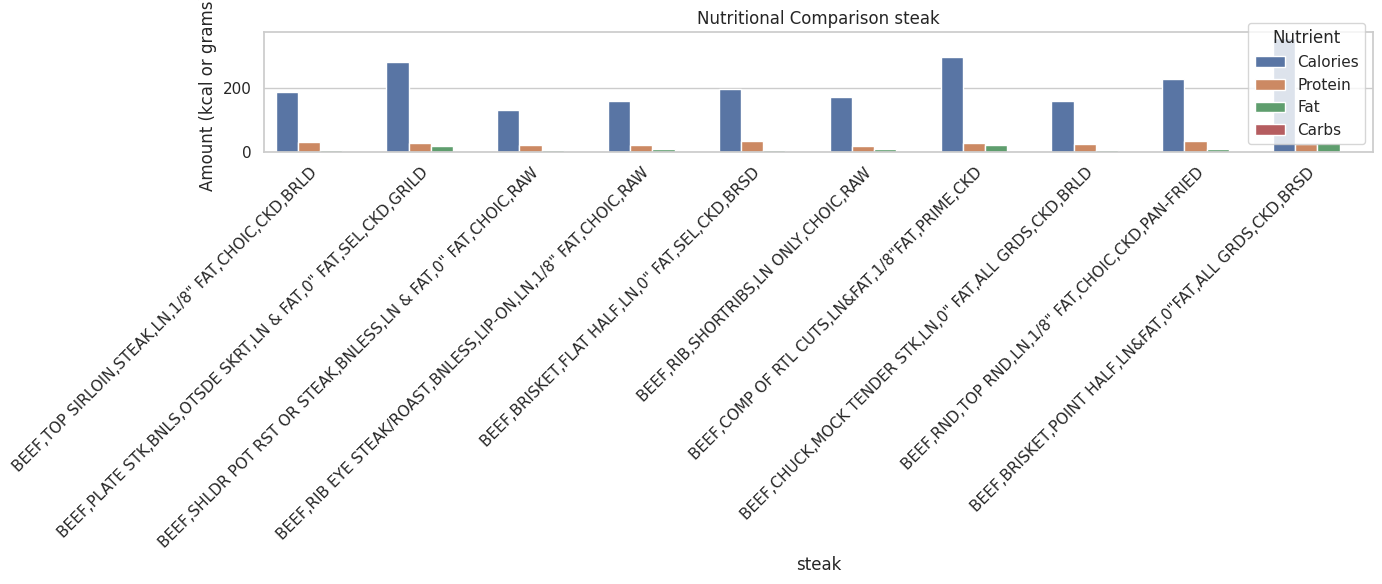

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
data =all_passages
records = []
for entry in data:
    name_part, nutrition_part = entry.split(': ')
    name = name_part.strip()
    parts = nutrition_part.split(', ')
    kcal = float(parts[0].replace('kcal', '').strip())
    protein = float(parts[1].replace('g protein', '').strip())
    fat = float(parts[2].replace('g fat', '').strip())
    carbs = float(parts[3].replace('g carbs.', '').strip())
    
    records.append({
        'Name': name,
        'Calories': kcal,
        'Protein': protein,
        'Fat': fat,
        'Carbs': carbs
    })

# Create DataFrame
df = pd.DataFrame(records)

# Melt the DataFrame for grouped bar plot
df_melted = df.melt(id_vars='Name', value_vars=['Calories', 'Protein', 'Fat', 'Carbs'],
                    var_name='Nutrient', value_name='Amount')

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=df_melted, x='Name', y='Amount', hue='Nutrient')
plt.xticks(rotation=45, ha='right')
plt.title('Nutritional Comparison '+ fav_food)
plt.xlabel(fav_food)
plt.ylabel('Amount (kcal or grams)')
plt.tight_layout()
plt.legend(title='Nutrient')
plt.show()